# CHALLENGE: Model Preparation

## <br>By Jean-Philippe Pitteloud</br>

### Requirements

In [1]:
import numpy as np
import pandas as pd
from sqlalchemy import create_engine
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats.stats import ttest_ind
from scipy.stats.mstats import winsorize
%matplotlib inline

warnings.filterwarnings('ignore')

### Data Gathering

In [2]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'lifeexpectancy'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

lifeexp_df = pd.read_sql_query('select * from lifeexpectancy',con=engine)

# no need for an open connection, 
# as we're only doing 
engine.dispose()

In [3]:
lifeexp_df.head()

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


In [4]:
lifeexp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
Country                            2938 non-null object
Year                               2938 non-null int64
Status                             2938 non-null object
Life expectancy                    2928 non-null float64
Adult Mortality                    2928 non-null float64
infant deaths                      2938 non-null int64
Alcohol                            2744 non-null float64
percentage expenditure             2938 non-null float64
Hepatitis B                        2385 non-null float64
Measles                            2938 non-null int64
 BMI                               2904 non-null float64
under-five deaths                  2938 non-null int64
Polio                              2919 non-null float64
Total expenditure                  2712 non-null float64
Diphtheria                         2919 non-null float64
 HIV/AIDS                          2938 non-null

From the summary above, it can be seen that the dataset is comprised of 2938 records and 22 columns/variables. Also, most of the columns have varying number of records missing and will need further assessing

In [5]:
lifeexp_df.isnull().sum()*100/lifeexp_df.isnull().count()

Country                             0.000000
Year                                0.000000
Status                              0.000000
Life expectancy                     0.340368
Adult Mortality                     0.340368
infant deaths                       0.000000
Alcohol                             6.603131
percentage expenditure              0.000000
Hepatitis B                        18.822328
Measles                             0.000000
 BMI                                1.157250
under-five deaths                   0.000000
Polio                               0.646698
Total expenditure                   7.692308
Diphtheria                          0.646698
 HIV/AIDS                           0.000000
GDP                                15.248468
Population                         22.191967
 thinness  1-19 years               1.157250
 thinness 5-9 years                 1.157250
Income composition of resources     5.684139
Schooling                           5.547992
dtype: flo

From all the available features, the variables 'Hepatitis B', 'GDP', and 'Population' report the highest number of missing records with 18%, 15%, and 22%, respectively. A detailed assessment of this features is needed to devise the best approach to address this data quality issues

### Data Cleaning

In [6]:
lifeexp_df_clean = lifeexp_df.copy()

Before assessing the quality of the dataset, a simple transformation of the column titles was accomplished using the function below. The use of this transformation allowed the simplification of all column names therefore facilitating their exploration and handling 

In [7]:
def format_columns(df):
    df.columns = df.columns.str.strip().str.lower().str.replace(r'\s+', '_')
    return df.columns

In [8]:
format_columns(lifeexp_df_clean)

Index(['country', 'year', 'status', 'life_expectancy', 'adult_mortality',
       'infant_deaths', 'alcohol', 'percentage_expenditure', 'hepatitis_b',
       'measles', 'bmi', 'under-five_deaths', 'polio', 'total_expenditure',
       'diphtheria', 'hiv/aids', 'gdp', 'population', 'thinness_1-19_years',
       'thinness_5-9_years', 'income_composition_of_resources', 'schooling'],
      dtype='object')

#### Missing Values

In an attempt to assess the quality of our dataset and considering the variable 'life_expectancy' as the target of this investigation, the relationship between each variable and the target variable was explored using their correlation coefficients

In [9]:
corr_mat = lifeexp_df_clean.corr()
corr_mat

,year,life_expectancy,adult_mortality,infant_deaths,alcohol,percentage_expenditure,hepatitis_b,measles,bmi,under-five_deaths,polio,total_expenditure,diphtheria,hiv/aids,gdp,population,thinness_1-19_years,thinness_5-9_years,income_composition_of_resources,schooling
year,1.000000,0.170033,-0.079052,-0.037415,-0.052990,0.031400,0.104333,-0.082493,0.108974,-0.042937,0.094158,0.090740,0.134337,-0.139741,0.101620,0.016969,-0.047876,-0.050929,0.243468,0.209400
life_expectancy,0.170033,1.000000,-0.696359,-0.196557,0.404877,0.381864,0.256762,-0.157586,0.567694,-0.222529,0.465556,0.218086,0.479495,-0.556556,0.461455,-0.021538,-0.477183,-0.471584,0.724776,0.751975
adult_mortality,-0.079052,-0.696359,1.000000,0.078756,-0.195848,-0.242860,-0.162476,0.031176,-0.387017,0.094146,-0.274823,-0.115281,-0.275131,0.523821,-0.296049,-0.013647,0.302904,0.308457,-0.457626,-0.454612
infant_deaths,-0.037415,-0.196557,0.078756,1.000000,-0.115638,-0.085612,-0.223566,0.501128,-0.227279,0.996629,-0.170689,-0.128616,-0.175171,0.025231,-0.108427,0.556801,0.465711,0.471350,-0.145139,-0.193720
alcohol,-0.052990,0.404877,-0.195848,-0.115638,1.000000,0.341285,0.087549,-0.051827,0.330408,-0.112370,0.221734,0.296942,0.222020,-0.048845,0.354712,-0.035252,-0.428795,-0.417414,0.450040,0.547378
percentage_expenditure,0.031400,0.381864,-0.242860,-0.085612,0.341285,1.000000,0.016274,-0.056596,0.228700,-0.087852,0.147259,0.174420,0.143624,-0.097857,0.899373,-0.025662,-0.251369,-0.252905,0.381952,0.389687
hepatitis_b,0.104333,0.256762,-0.162476,-0.223566,0.087549,0.016274,1.000000,-0.120529,0.150380,-0.233126,0.486171,0.058280,0.611495,-0.112675,0.083903,-0.123321,-0.120429,-0.124960,0.199549,0.231117
measles,-0.082493,-0.157586,0.031176,0.501128,-0.051827,-0.056596,-0.120529,1.000000,-0.175977,0.507809,-0.136166,-0.106241,-0.141882,0.030899,-0.076466,0.265966,0.224808,0.221072,-0.129568,-0.137225
bmi,0.108974,0.567694,-0.387017,-0.227279,0.330408,0.228700,0.150380,-0.175977,1.000000,-0.237669,0.284569,0.242503,0.283147,-0.243717,0.301557,-0.072301,-0.532025,-0.538911,0.508774,0.546961
under-five_deaths,-0.042937,-0.222529,0.094146,0.996629,-0.112370,-0.087852,-0.233126,0.507809,-0.237669,1.000000,-0.188720,-0.130148,-0.195668,0.038062,-0.112081,0.544423,0.467789,0.472263,-0.163305,-0.209373


From the table above, we can conclude that a variable like 'population', with 22% of its records missing, has very little correlation with our target variable 'life_expectancy'. For this reason, 'population' could be eliminated with little impact to the study, however, further investigation on the distribution of those missing values may be useful. In order to get more insight into this distribution, a dataframe was derived to count the number of missing records for each country and each feature

In [10]:
null_df2 = lifeexp_df_clean.set_index('country')

In [11]:
null_df2.isna().groupby('country').sum()

,year,status,life_expectancy,adult_mortality,infant_deaths,alcohol,percentage_expenditure,hepatitis_b,measles,bmi,...,polio,total_expenditure,diphtheria,hiv/aids,gdp,population,thinness_1-19_years,thinness_5-9_years,income_composition_of_resources,schooling
country,,,,,,,,,,,,,,,,,,,,,
Afghanistan,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Albania,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Algeria,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Angola,0.0,0.0,0.0,0.0,0.0,1.0,0.0,7.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Antigua and Barbuda,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,16.0,0.0,0.0,0.0,0.0
Argentina,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Armenia,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Australia,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Austria,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In the table above, it can be seen that most of the missing records in the 'population' column are concentrated over specific countries in which the figures of 'population' were not reported for any of the years that comprise the study (2000-2015). This fact makes really hard any effort to input or replace the missing values using any of the frequently employed approaches. A similar trend can be also observed in columns like 'hepatitis_b' and 'gdp'. In the case of the 'hepatitis_b' feature, the availability of other features related to vaccination might offer an efficient approach of inputting the missing values using the median or mean of the available values for the same country during the same year. As an alternative, the creation of a feature named 'vaccination' that includes the mean of all vaccination features might be useful. In the case of countries missing records of 'gdp' for all 16 years of the study, exclusion of those countries from the dataset might be the only efficient approach to address the missing values

In [12]:
null_df = lifeexp_df_clean.set_index('year')

In [13]:
null_df.isna().groupby('year').sum()

,country,status,life_expectancy,adult_mortality,infant_deaths,alcohol,percentage_expenditure,hepatitis_b,measles,bmi,...,polio,total_expenditure,diphtheria,hiv/aids,gdp,population,thinness_1-19_years,thinness_5-9_years,income_composition_of_resources,schooling
year,,,,,,,,,,,,,,,,,,,,,
2000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,98.0,0.0,2.0,...,3.0,4.0,3.0,0.0,29.0,40.0,2.0,2.0,10.0,10.0
2001,0.0,0.0,0.0,0.0,0.0,1.0,0.0,88.0,0.0,2.0,...,3.0,4.0,3.0,0.0,28.0,40.0,2.0,2.0,10.0,10.0
2002,0.0,0.0,0.0,0.0,0.0,1.0,0.0,70.0,0.0,2.0,...,2.0,4.0,2.0,0.0,28.0,40.0,2.0,2.0,10.0,10.0
2003,0.0,0.0,0.0,0.0,0.0,1.0,0.0,52.0,0.0,2.0,...,2.0,3.0,2.0,0.0,28.0,40.0,2.0,2.0,10.0,10.0
2004,0.0,0.0,0.0,0.0,0.0,1.0,0.0,45.0,0.0,2.0,...,2.0,3.0,2.0,0.0,27.0,40.0,2.0,2.0,10.0,10.0
2005,0.0,0.0,0.0,0.0,0.0,2.0,0.0,36.0,0.0,2.0,...,2.0,3.0,2.0,0.0,27.0,40.0,2.0,2.0,10.0,10.0
2006,0.0,0.0,0.0,0.0,0.0,1.0,0.0,32.0,0.0,2.0,...,1.0,3.0,1.0,0.0,27.0,40.0,2.0,2.0,10.0,10.0
2007,0.0,0.0,0.0,0.0,0.0,1.0,0.0,24.0,0.0,2.0,...,1.0,3.0,1.0,0.0,27.0,40.0,2.0,2.0,10.0,10.0
2008,0.0,0.0,0.0,0.0,0.0,1.0,0.0,20.0,0.0,2.0,...,1.0,3.0,1.0,0.0,27.0,40.0,2.0,2.0,10.0,10.0


Similar exploration of the distribution of the missing values but by 'year' instead of country confirms the idea that some particular countries concentrate the majority of missing values in columns such as 'gdp' and 'population'. In contrast, the missing values in the column 'hepatitis_b' seem to be caused by either lack of reporting in the early years of the study or a widespread increase in the administration of this vaccine over the years reported in the dataset. Also, worth noting is the high number of missing records in fields like 'alcohol' and 'total_expenditure' during 2015 with records missing for 177 and 181 countries out of the 193 countries included in the dataset. An exploration of the distribution of the values in these variables for a sample of countries during 2000-2014 will be needed to find the best approach to address those missing values

Based on the reasons discussed above, the column 'population' was removed from the dataset

In [14]:
lifeexp_df_clean = lifeexp_df_clean.drop('population', axis = 1) 

In [15]:
lifeexp_df_clean['vaccination'] = lifeexp_df_clean[['hepatitis_b', 'polio', 'diphtheria']].mean(axis = 1)

In [16]:
lifeexp_df_clean.corr().loc[['life_expectancy', 'hepatitis_b', 'polio', 'diphtheria', 'vaccination'], ['life_expectancy', 'hepatitis_b', 'polio', 'diphtheria', 'vaccination']]

,life_expectancy,hepatitis_b,polio,diphtheria,vaccination
life_expectancy,1.000000,0.256762,0.465556,0.479495,0.502534
hepatitis_b,0.256762,1.000000,0.486171,0.611495,0.849157
polio,0.465556,0.486171,1.000000,0.673553,0.857911
diphtheria,0.479495,0.611495,0.673553,1.000000,0.898002
vaccination,0.502534,0.849157,0.857911,0.898002,1.000000


As it can be seen in the summary table below, the creation of a 'vaccination' feature significantly decreased the number of missing records to 19 and it is more correlated to the target variable 'life_expectancy' than the original features, however, a closer look into the still missing records revealed that three countries accumulate the missing records. Montenegro, South Sudan, and Timor-Leste (see below) were not recognized as countries during some of the years in the period between 2000-2015 leading to missing records in certain fields and inconsistencies in the existing records. For these reasons, the mentioned countries were removed from the dataset. The original features 'hepatitis_b', 'polio', and 'diphtheria' were removed from the dataset in favor of the new 'vaccination' feature

In [17]:
lifeexp_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
country                            2938 non-null object
year                               2938 non-null int64
status                             2938 non-null object
life_expectancy                    2928 non-null float64
adult_mortality                    2928 non-null float64
infant_deaths                      2938 non-null int64
alcohol                            2744 non-null float64
percentage_expenditure             2938 non-null float64
hepatitis_b                        2385 non-null float64
measles                            2938 non-null int64
bmi                                2904 non-null float64
under-five_deaths                  2938 non-null int64
polio                              2919 non-null float64
total_expenditure                  2712 non-null float64
diphtheria                         2919 non-null float64
hiv/aids                           2938 non-null

In [18]:
lifeexp_df_clean[lifeexp_df_clean['vaccination'].isna()][['country', 'year', 'hepatitis_b', 'polio', 'diphtheria', 'vaccination']]

,country,year,hepatitis_b,polio,diphtheria,vaccination
1743,Montenegro,2005,NaN,NaN,NaN,NaN
1744,Montenegro,2004,NaN,NaN,NaN,NaN
1745,Montenegro,2003,NaN,NaN,NaN,NaN
1746,Montenegro,2002,NaN,NaN,NaN,NaN
1747,Montenegro,2001,NaN,NaN,NaN,NaN
1748,Montenegro,2000,NaN,NaN,NaN,NaN
2414,South Sudan,2010,NaN,NaN,NaN,NaN
2415,South Sudan,2009,NaN,NaN,NaN,NaN
2416,South Sudan,2008,NaN,NaN,NaN,NaN
2417,South Sudan,2007,NaN,NaN,NaN,NaN


In [19]:
index_names = (lifeexp_df_clean[lifeexp_df_clean['country'] == 'Montenegro'] | lifeexp_df_clean[lifeexp_df_clean['country'] == 'South Sudan'] | lifeexp_df_clean[lifeexp_df_clean['country'] == 'Timor-Leste']).index

lifeexp_df_clean.drop(index_names, inplace = True)

Upon creation of the 'vaccination' feauture, the original fields 'hepatitis_b', 'polio', and 'diphtheria' were removed from the dataset

In [20]:
lifeexp_df_clean.drop(['hepatitis_b', 'polio', 'diphtheria'], axis = 1, inplace = True)

In [21]:
lifeexp_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2890 entries, 0 to 2937
Data columns (total 19 columns):
country                            2890 non-null object
year                               2890 non-null int64
status                             2890 non-null object
life_expectancy                    2880 non-null float64
adult_mortality                    2880 non-null float64
infant_deaths                      2890 non-null int64
alcohol                            2715 non-null float64
percentage_expenditure             2890 non-null float64
measles                            2890 non-null int64
bmi                                2872 non-null float64
under-five_deaths                  2890 non-null int64
total_expenditure                  2679 non-null float64
hiv/aids                           2890 non-null float64
gdp                                2450 non-null float64
thinness_1-19_years                2872 non-null float64
thinness_5-9_years                 2872 non-null

The next feature reporting a high proportion of missing values is 'gdp'. A detailed look into the distribution of missing records in this field. As it can be seen in the summary table below, most of the countries that report missing records for the variable 'gdp' do it in high numbers. For example, "Bahamas" is missing figures of 'gdp' for the entirety of the period comprised in the dataset (16 years). The same trends is shared by major players in the global economy like "Democratic People's Republic of Korea", "United Kingdom of Great Britain and Northern Ireland", and "United States of America"

In [22]:
lifeexp_df_clean[lifeexp_df_clean['gdp'].isna()][['year', 'country']].groupby('country').count()

,year
country,
Bahamas,16
Bolivia (Plurinational State of),16
Congo,16
Cook Islands,1
Czechia,16
Côte d'Ivoire,16
Democratic People's Republic of Korea,16
Democratic Republic of the Congo,16
Egypt,16


In order to address this issue, a closer look was taken at other features that consider the 'Gross Domestic Product (gdp)' in their calculations and envision its use as possible substitutes of the 'gdp' column. First, the correlation between those fields and the target was evaluated through a correlation matrix

In [23]:
lifeexp_df_clean.corr().loc[['life_expectancy', 'gdp', 'percentage_expenditure', 'total_expenditure'], ['life_expectancy', 'gdp', 'percentage_expenditure', 'total_expenditure']]

,life_expectancy,gdp,percentage_expenditure,total_expenditure
life_expectancy,1.000000,0.461494,0.381862,0.213349
gdp,0.461494,1.000000,0.899224,0.135317
percentage_expenditure,0.381862,0.899224,1.000000,0.172940
total_expenditure,0.213349,0.135317,0.172940,1.000000


From the table above, it can be seen that 'gdp' and 'percentage_expenditure' share a strong correlation (0.899) among themselves, and both correlate similarly (within error) with the target variable 'life_expectancy'. Taking a closer look at the description offered for both variables,

- **percentage_expenditure:** Expenditure on health as a percentage of Gross Domestic Product per capita(%)

- **gdp:** Gross Domestic Product per capita (in USD)

we can see that both are related in nature through the use of 'gdp' figures, for this reason the removal of 'gdp' from the dataset was justified in favor of a more complete variable, 'percentage_expenditure' 

In [24]:
lifeexp_df_clean.drop('gdp', axis = 1, inplace = True)

Further investigation of the dataset revealed that most of the countries effectively reported values for the period of interest between 2000 and 2015, while few others only reported data for a single year. In the list below, some countries such as "Tuvalu" are present in the dataset once and many of the reported values are either missing or supected inconsistent. A list of the countries is offered below:
- Cook Islands
- Dominica
- Marshall Islands
- Monaco
- Nauru
- Niue
- Palau
- Saint Kitts and Nevis
- San Marino
- Tuvalu

To ensure consistency in our working dataset, the records from this countries were removed

In [25]:
lifeexp_df_clean.groupby('country')['year'].count()

country
Afghanistan                                             16
Albania                                                 16
Algeria                                                 16
Angola                                                  16
Antigua and Barbuda                                     16
Argentina                                               16
Armenia                                                 16
Australia                                               16
Austria                                                 16
Azerbaijan                                              16
Bahamas                                                 16
Bahrain                                                 16
Bangladesh                                              16
Barbados                                                16
Belarus                                                 16
Belgium                                                 16
Belize                                          

In [26]:
countries = ['Cook Islands', 'Dominica', 'Marshall Islands', 'Monaco', 'Nauru', 'Niue', 'Palau', 'Saint Kitts and Nevis', 'San Marino', 'Tuvalu']

for country in countries:
    index = lifeexp_df_clean[lifeexp_df_clean['country'] == country].index
    lifeexp_df_clean.drop(index, axis = 0, inplace = True)

In [27]:
lifeexp_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2880 entries, 0 to 2937
Data columns (total 18 columns):
country                            2880 non-null object
year                               2880 non-null int64
status                             2880 non-null object
life_expectancy                    2880 non-null float64
adult_mortality                    2880 non-null float64
infant_deaths                      2880 non-null int64
alcohol                            2706 non-null float64
percentage_expenditure             2880 non-null float64
measles                            2880 non-null int64
bmi                                2864 non-null float64
under-five_deaths                  2880 non-null int64
total_expenditure                  2669 non-null float64
hiv/aids                           2880 non-null float64
thinness_1-19_years                2864 non-null float64
thinness_5-9_years                 2864 non-null float64
income_composition_of_resources    2720 non-null

As it can be seen in the table above, up to this point most of the missing values in our dataset have been addressed, however, there is still work to be done. For example, in the fields 'thinness_1-19_years' and 'thinness_5-9_years', there are just 16 records missing. This number of missing records matches the number of years reported by the countries in the dataset, so a more detailed look into the distribution of these missing records may shed some light into an efficient approach to address them

In [28]:
lifeexp_df_clean[lifeexp_df_clean['thinness_1-19_years'].isna()][['country', 'year', 'thinness_1-19_years', 'thinness_5-9_years']]

,country,year,thinness_1-19_years,thinness_5-9_years
2457,Sudan,2015,NaN,NaN
2458,Sudan,2014,NaN,NaN
2459,Sudan,2013,NaN,NaN
2460,Sudan,2012,NaN,NaN
2461,Sudan,2011,NaN,NaN
2462,Sudan,2010,NaN,NaN
2463,Sudan,2009,NaN,NaN
2464,Sudan,2008,NaN,NaN
2465,Sudan,2007,NaN,NaN
2466,Sudan,2006,NaN,NaN


From the subset of the dataset presented above, it is evident that all missing records for both variables ''thinness_1-19_years' and 'thinness_5-9_years' are attributed to the same country 'Sudan'. Due to the lack of any reference value to replace the missing values, all records from 'Sudan' were also removed from the dataset

In [29]:
lifeexp_df_clean.drop(lifeexp_df_clean[lifeexp_df_clean['country'] == 'Sudan'].index, axis = 0, inplace = True)

In [30]:
lifeexp_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2864 entries, 0 to 2937
Data columns (total 18 columns):
country                            2864 non-null object
year                               2864 non-null int64
status                             2864 non-null object
life_expectancy                    2864 non-null float64
adult_mortality                    2864 non-null float64
infant_deaths                      2864 non-null int64
alcohol                            2691 non-null float64
percentage_expenditure             2864 non-null float64
measles                            2864 non-null int64
bmi                                2864 non-null float64
under-five_deaths                  2864 non-null int64
total_expenditure                  2654 non-null float64
hiv/aids                           2864 non-null float64
thinness_1-19_years                2864 non-null float64
thinness_5-9_years                 2864 non-null float64
income_composition_of_resources    2704 non-null

As it can be seen from the summary table above, data cleaning efforts left only the following variables containing missing values:
- alcohol
- total expenditure
- income_composition_of_resources
- schooling

From this group of variables, the last two were found to be very correlated to the target variable. In order to know more about the distribution of missing values in the last two variables listed above, a table of countries is displayed below

In [31]:
lifeexp_df_clean[lifeexp_df_clean['schooling'].isna()][['country', 'year', 'income_composition_of_resources', 'schooling']].groupby('country').count()

,year,income_composition_of_resources,schooling
country,,,
Czechia,16,0,0
Côte d'Ivoire,16,0,0
Democratic People's Republic of Korea,16,0,0
Democratic Republic of the Congo,16,0,0
Republic of Korea,16,0,0
Republic of Moldova,16,0,0
Somalia,16,0,0
United Kingdom of Great Britain and Northern Ireland,16,0,0
United Republic of Tanzania,16,0,0


In the table above, it can be seen that the totality of missing values in the variables 'income_composition_of_resources' and 'schooling' is equally distributed over ten countries. Some of these countries are listed as 'Developed' and some others as 'Developing'. In order to find the best approach for addressing the missing values, a comparison of the two 'status' groups (Develped and Developing) were subjected to a t-test

In [32]:
ttest_ind(lifeexp_df_clean[lifeexp_df_clean['status'] == 'Developed'][['schooling', 'income_composition_of_resources']].dropna(), lifeexp_df_clean[lifeexp_df_clean['status'] == 'Developing'][['schooling', 'income_composition_of_resources']].dropna())

Ttest_indResult(statistic=array([32.51457855, 28.7922552 ]), pvalue=array([5.18119147e-196, 3.14989496e-159]))

The results above, reveal that values in the variables 'schooling' and'income_composition_of_resources' are statistically different among the two 'status' groups. Therefore, the use of mean or median to replace the missing values is a likely option

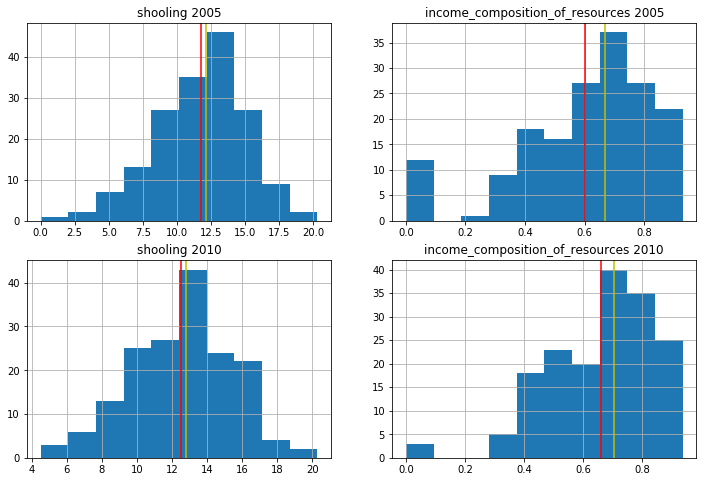

In [33]:
fig = plt.figure(figsize=(12,8))

plt.subplot(2, 2, 1)
lifeexp_df_clean[lifeexp_df_clean['year'] == 2005]['schooling'].hist()
plt.title('shooling 2005')
plt.axvline(lifeexp_df_clean[lifeexp_df_clean['year'] == 2005]['schooling'].mean(), c = 'r')
plt.axvline(lifeexp_df_clean[lifeexp_df_clean['year'] == 2005]['schooling'].median(), c = 'y')
    
plt.subplot(2, 2, 2)
lifeexp_df_clean[lifeexp_df_clean['year'] == 2005]['income_composition_of_resources'].hist()
plt.title('income_composition_of_resources 2005')
plt.axvline(lifeexp_df_clean[lifeexp_df_clean['year'] == 2005]['income_composition_of_resources'].mean(), c = 'r')
plt.axvline(lifeexp_df_clean[lifeexp_df_clean['year'] == 2005]['income_composition_of_resources'].median(), c = 'y')

plt.subplot(2, 2, 3)
lifeexp_df_clean[lifeexp_df_clean['year'] == 2010]['schooling'].hist()
plt.title('shooling 2010')
plt.axvline(lifeexp_df_clean[lifeexp_df_clean['year'] == 2010]['schooling'].mean(), c = 'r')
plt.axvline(lifeexp_df_clean[lifeexp_df_clean['year'] == 2010]['schooling'].median(), c = 'y')
    
plt.subplot(2, 2, 4)
lifeexp_df_clean[lifeexp_df_clean['year'] == 2010]['income_composition_of_resources'].hist()
plt.title('income_composition_of_resources 2010')
plt.axvline(lifeexp_df_clean[lifeexp_df_clean['year'] == 2010]['income_composition_of_resources'].mean(), c = 'r')
plt.axvline(lifeexp_df_clean[lifeexp_df_clean['year'] == 2010]['income_composition_of_resources'].median(), c = 'y');

Based on the histograms above, which depict the distribution of values in variables 'schooling' and 'income_composition_of_resources' for years 2005 and 2010, it can be seen that the "median" (yellow vertical line) represents more accurately the central tendendy of each variable compared to the "mean" (red vertical line). For this reason, the use of the median for the specific year will to replace missing values will represent a more convenient approach to prevent dramatic changes in the distribution and descriptive statistics of the mentioned variables

In [34]:
years = lifeexp_df_clean['year'].unique()
cols = ['income_composition_of_resources', 'schooling']
statuses = ['Developed', 'Developing']

for status in statuses:
    for year in years:
        for column in cols:
            mask = (lifeexp_df_clean['status'] == status) & (lifeexp_df_clean['year'] == year)
            median_income = lifeexp_df_clean.loc[mask, column].median()
            lifeexp_df_clean.loc[mask, column] = lifeexp_df_clean.loc[mask, column].fillna(median_income)

In order to address the missing values in the variables 'total_expenditure' and 'alcohol, their correlation to the target variable was calculated. Based on the chart below, the variable 'total_expenditure', which shares a similar description than the variable 'percentage_expenditure', presents a weaker correlation with the target variable. In order to prevent the use of redundant variables in at our modeling stage, the variable 'total_expenditure' was removed from the dataset in favor of the more correlated 'percentage_expenditure'

In [35]:
lifeexp_df_clean.corr().loc[['life_expectancy', 'total_expenditure', 'percentage_expenditure', 'alcohol'], ['life_expectancy', 'total_expenditure', 'percentage_expenditure', 'alcohol']]

,life_expectancy,total_expenditure,percentage_expenditure,alcohol
life_expectancy,1.000000,0.213263,0.381242,0.404373
total_expenditure,0.213263,1.000000,0.174956,0.300376
percentage_expenditure,0.381242,0.174956,1.000000,0.339492
alcohol,0.404373,0.300376,0.339492,1.000000


In [36]:
lifeexp_df_clean.drop('total_expenditure', axis = 1, inplace = True)

With respect to the last variable reporting missing values, 'alcohol', a quick look into the distribution of the values for a sample of countries revealed many inconsistencies in the distribution with very few countries showing normally distributed values, many countries showing bimodal distributions, and reporting zero/negative values. Since a detailed exploration of the feasibility of these values for every country in the dataset would be very tedious and inpractical, the variable 'alcohol' was also removed from our working dataset

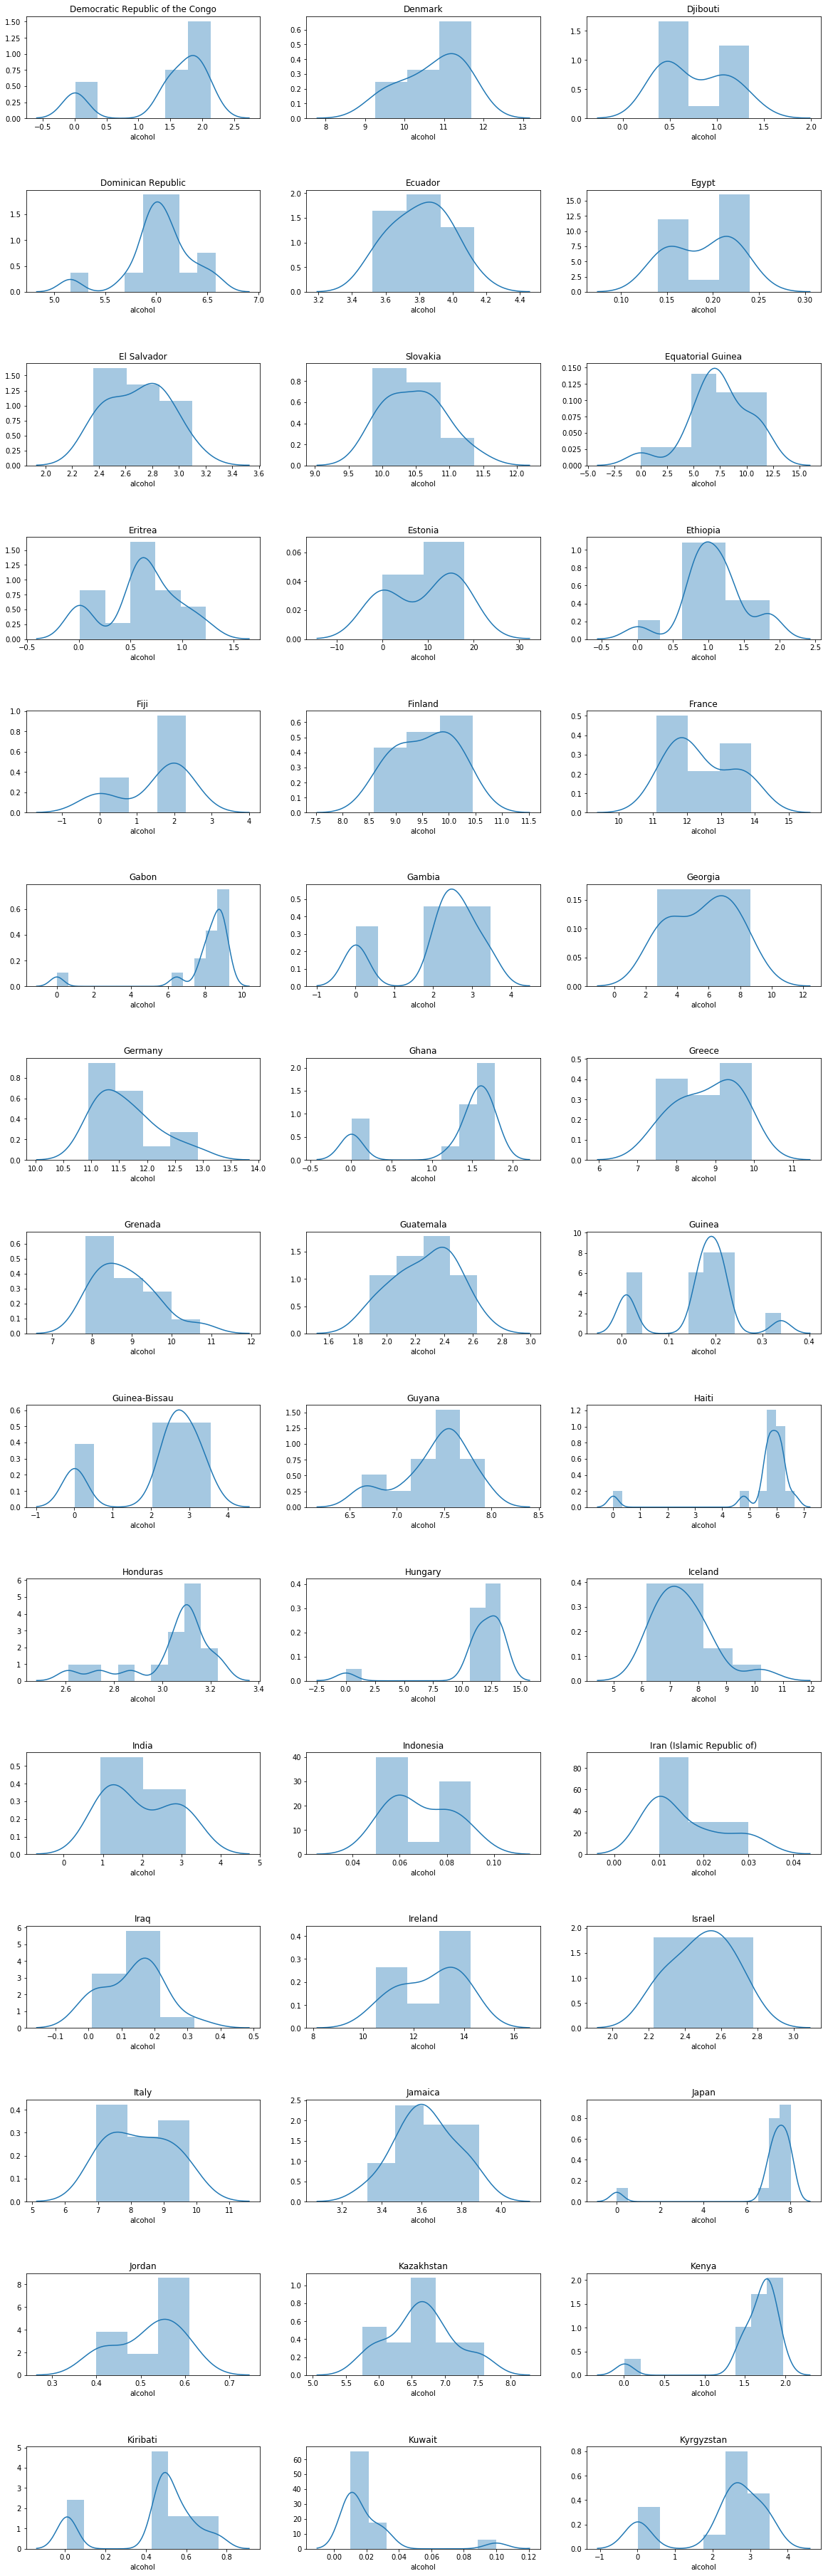

In [37]:
fig = plt.figure(figsize=(20,200))
plt.subplots_adjust(hspace = 0.7)

countries = lifeexp_df_clean['country'].unique()[45:90]

for i, country in enumerate(countries):
    plt.subplot(len(countries), 3, i+1)
    sns.distplot(lifeexp_df_clean[lifeexp_df_clean['country'] == country]['alcohol'].dropna())
    plt.title(country);

In [38]:
lifeexp_df_clean.drop('alcohol', axis = 1, inplace = True)

A re-evaluation of the nature of the remaining variables in terms of their correlations with the target variable ('life_expectancy'), suggests that three variables are somehow related to infant mortality. From the table below, it can be seen that among the three variables evaluated against the target, the variables 'infant_deaths' and 'under-five_deaths' are highly correlated with each other suggesting a high degree of redundancy bewteen their values. In contrast, the variable 'hiv/aids' has no correlation with these other two while keeping a much stronger correlation with the target variable. For these reasons, the variable 'infant_deaths' was removed from the dataset. The relationship observed between 'hiv/aids' and 'life_expectancy' is likely to be multifactorial since HIV/AIDS is often associated with poverty indicators that may have a more direct influence in life expectancy

In [39]:
lifeexp_df_clean.corr().loc[['life_expectancy', 'infant_deaths', 'under-five_deaths', 'hiv/aids'], ['life_expectancy', 'infant_deaths', 'under-five_deaths', 'hiv/aids']]

,life_expectancy,infant_deaths,under-five_deaths,hiv/aids
life_expectancy,1.000000,-0.197601,-0.223407,-0.561231
infant_deaths,-0.197601,1.000000,0.996634,0.024638
under-five_deaths,-0.223407,0.996634,1.000000,0.037495
hiv/aids,-0.561231,0.024638,0.037495,1.000000


In [40]:
lifeexp_df_clean.drop('infant_deaths', axis = 1, inplace = True)

In [41]:
lifeexp_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2864 entries, 0 to 2937
Data columns (total 15 columns):
country                            2864 non-null object
year                               2864 non-null int64
status                             2864 non-null object
life_expectancy                    2864 non-null float64
adult_mortality                    2864 non-null float64
percentage_expenditure             2864 non-null float64
measles                            2864 non-null int64
bmi                                2864 non-null float64
under-five_deaths                  2864 non-null int64
hiv/aids                           2864 non-null float64
thinness_1-19_years                2864 non-null float64
thinness_5-9_years                 2864 non-null float64
income_composition_of_resources    2864 non-null float64
schooling                          2864 non-null float64
vaccination                        2864 non-null float64
dtypes: float64(10), int64(3), object(2)
memor

As it can be seen in the summary table above, all available variables after the data cleaning efforts are complete in terms of missing values. Next, a detailed evaluation of the variables in terms of potential outliers and extreme values would be conducted

In [42]:
lifeexp_df_clean.columns

Index(['country', 'year', 'status', 'life_expectancy', 'adult_mortality',
       'percentage_expenditure', 'measles', 'bmi', 'under-five_deaths',
       'hiv/aids', 'thinness_1-19_years', 'thinness_5-9_years',
       'income_composition_of_resources', 'schooling', 'vaccination'],
      dtype='object')

#### Outliers

In order to address evaluate potential outliers and/or extreme values in the available fields, a series of box plots were created and presented below

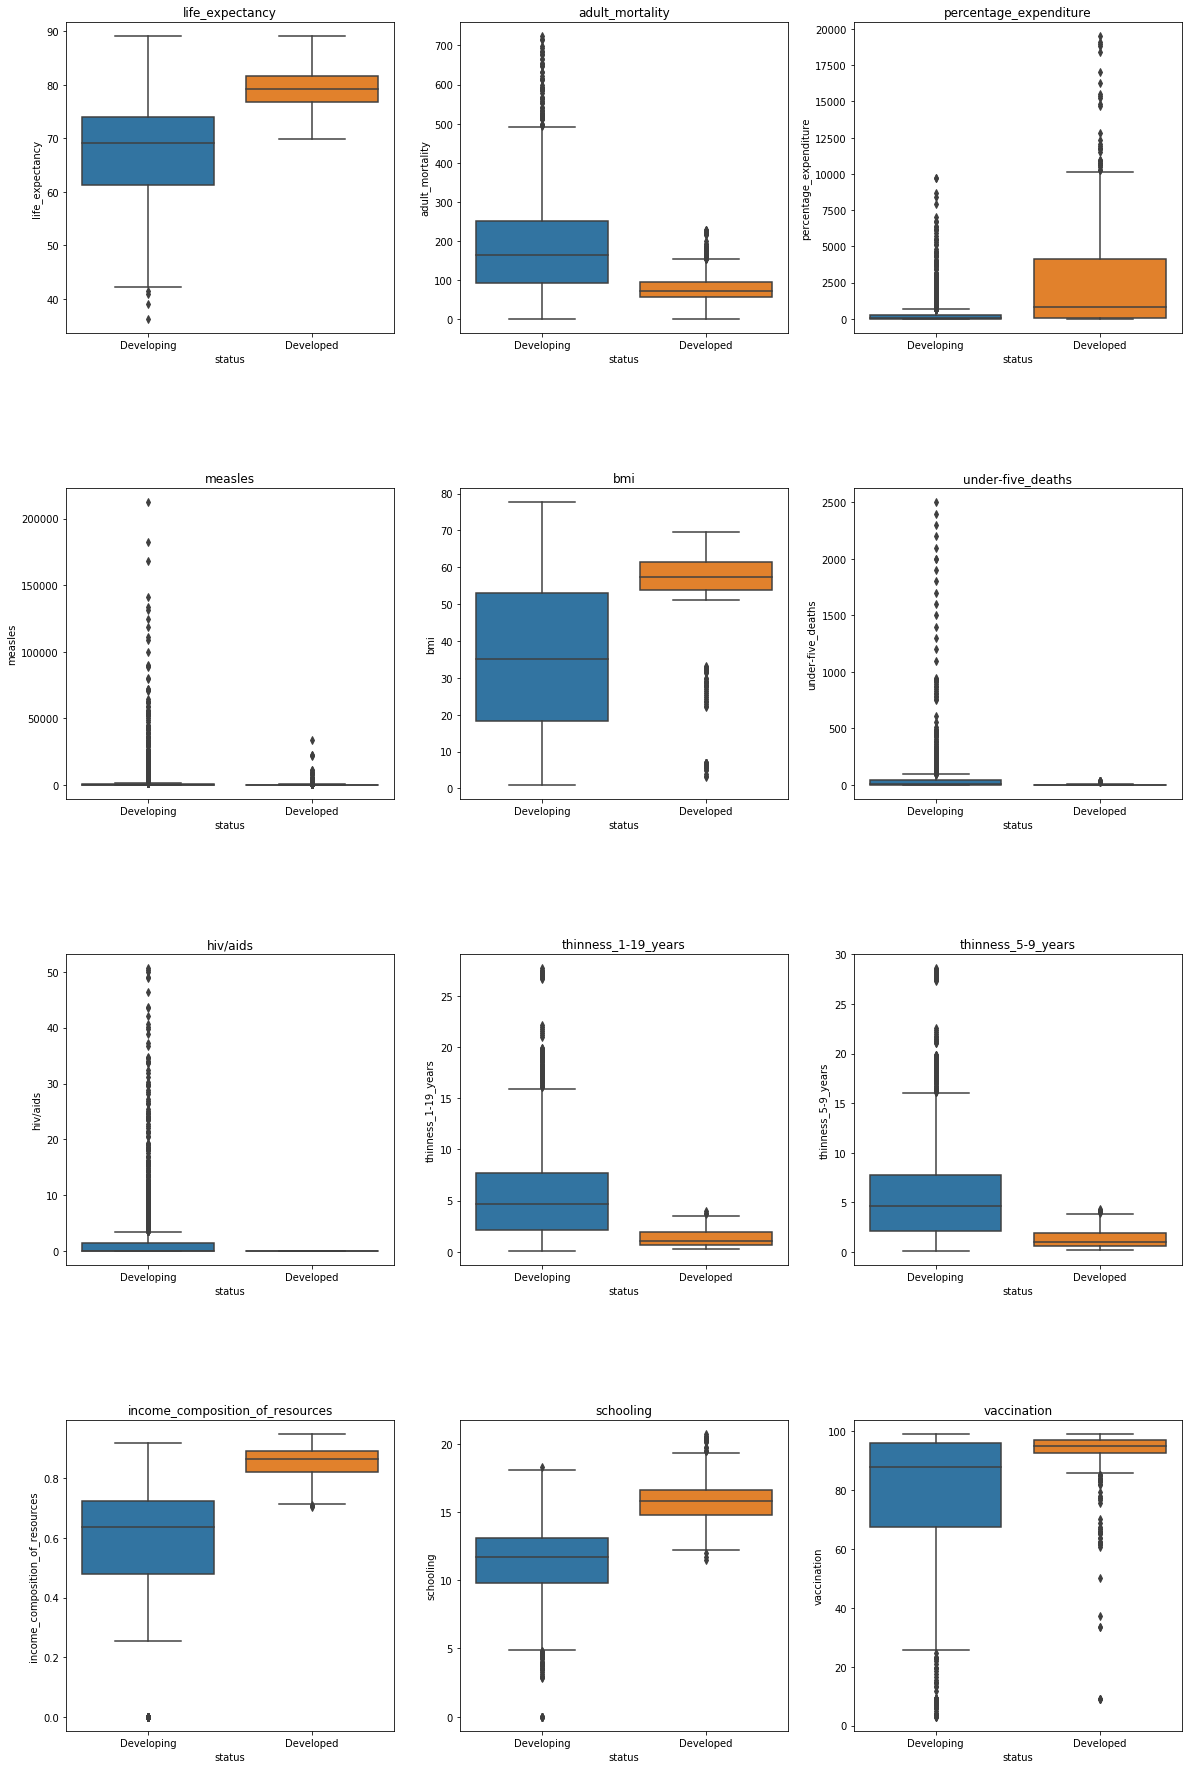

In [43]:
fig = plt.figure(figsize=(20,100))
plt.subplots_adjust(hspace = 0.5)

num_cols = ['life_expectancy', 'adult_mortality',
       'percentage_expenditure', 'measles', 'bmi', 'under-five_deaths',
       'hiv/aids', 'thinness_1-19_years', 'thinness_5-9_years',
       'income_composition_of_resources', 'schooling', 'vaccination']

for i, column in enumerate(num_cols):
    plt.subplot(len(num_cols), 3, i+1)
    sns.boxplot(data = lifeexp_df_clean, y = column, x = 'status')
    plt.title(column);

As it can be seen in the plots above, most of the fields have potential outliers in both levels of 'status'. As first step in the proccess of addressing the mentioned outliers, winsorization of the features by country was performed

In [44]:
countries = lifeexp_df_clean['country'].unique()

cols = ['life_expectancy', 'adult_mortality',
       'percentage_expenditure', 'measles', 'bmi', 'under-five_deaths',
       'hiv/aids', 'thinness_1-19_years', 'thinness_5-9_years',
       'income_composition_of_resources', 'schooling', 'vaccination']

for country in countries:
    for column in cols:
        mask = lifeexp_df_clean['country'] == country
        lifeexp_df_clean.loc[mask, column] = winsorize(lifeexp_df_clean.loc[mask, column], (0.5, 0.5))

Upon winsorization, the bivariate interaction between the available numeric variables and their corresponding histograms offer a better picture about distribution and nature of outliers and extreme values. The analysis of these plots combined with correlation values calculated through the correlation matrix shown below, highlight the high density of zero values in fields such as 'percentage_expenditure', 'measles', and 'under-five_deaths'. The low correlation between 'measles' and 'under-five_deaths' and the target variable 'life_expectancy' dramatically reduce their predictive power and should not be considered in the modeling stages of the project. Therefore, these two variables along 'percentage_expenditure' were removed from our working dataset

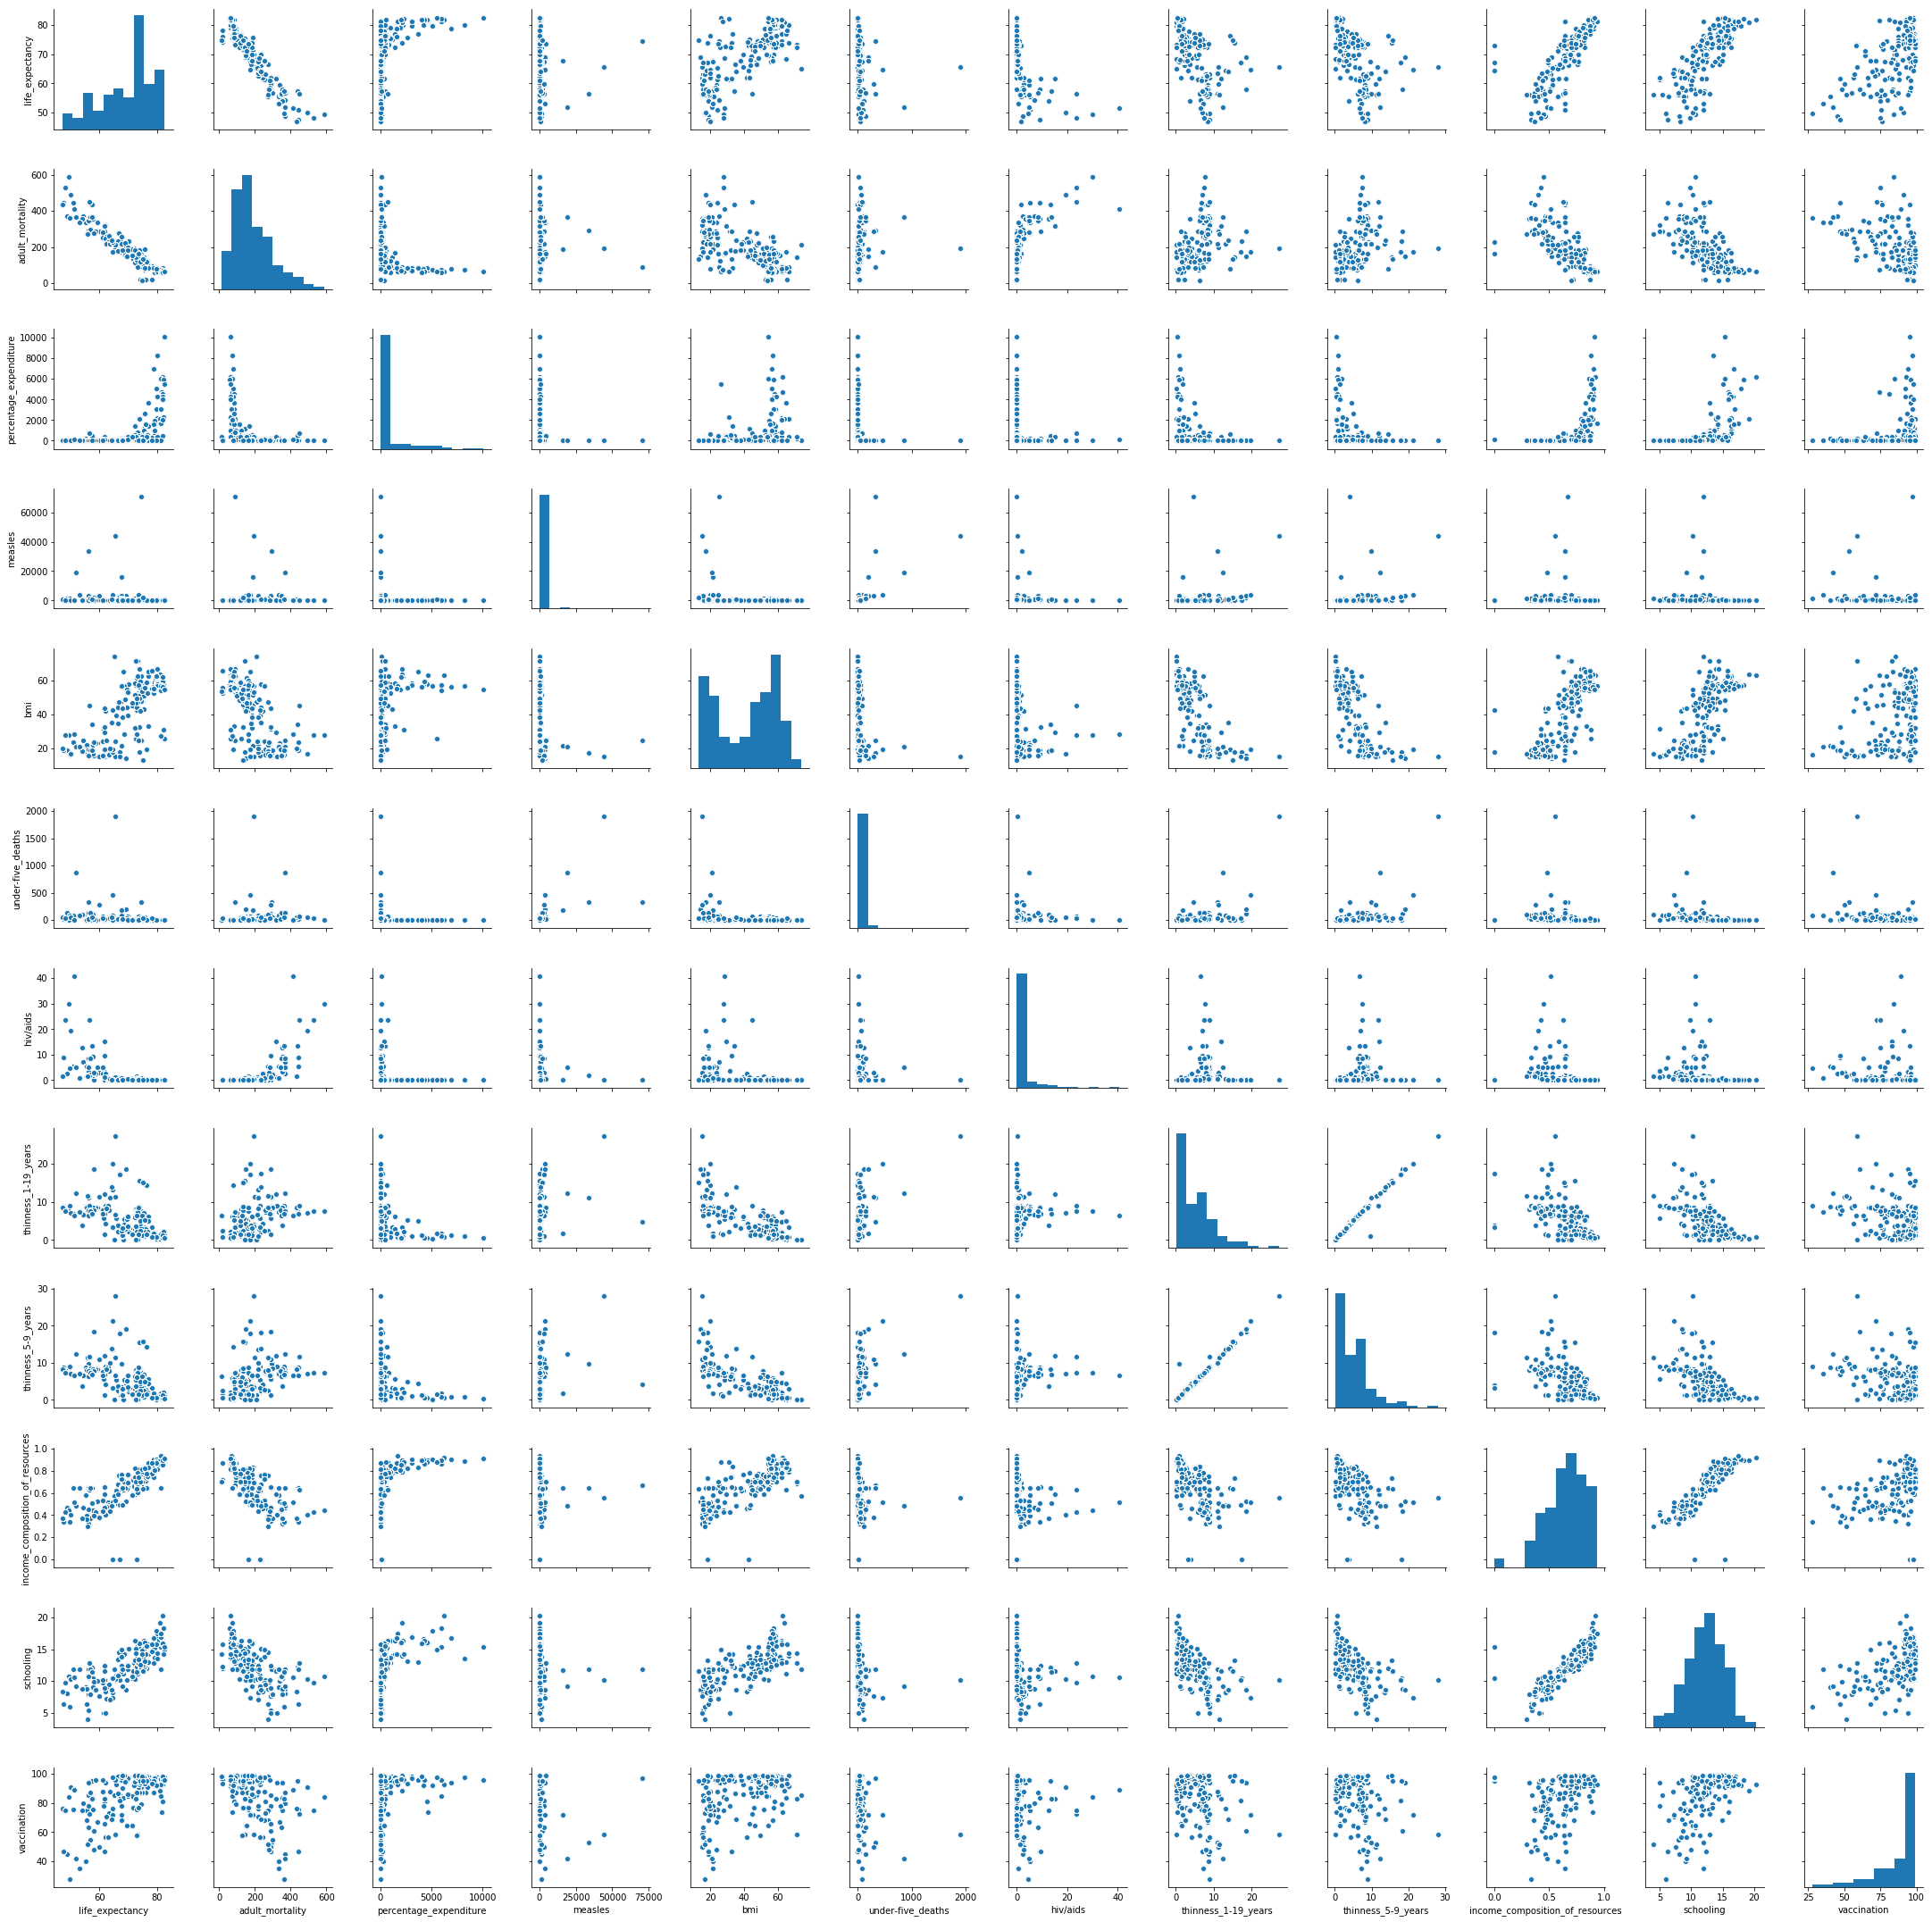

In [45]:
sns.pairplot(lifeexp_df_clean[['life_expectancy', 'adult_mortality',
       'percentage_expenditure', 'measles', 'bmi', 'under-five_deaths',
       'hiv/aids', 'thinness_1-19_years', 'thinness_5-9_years',
       'income_composition_of_resources', 'schooling', 'vaccination']]);

In [46]:
lifeexp_df_clean[['life_expectancy', 'adult_mortality',
       'percentage_expenditure', 'measles', 'bmi', 'under-five_deaths',
       'hiv/aids', 'thinness_1-19_years', 'thinness_5-9_years',
       'income_composition_of_resources', 'schooling', 'vaccination']].corr()

,life_expectancy,adult_mortality,percentage_expenditure,measles,bmi,under-five_deaths,hiv/aids,thinness_1-19_years,thinness_5-9_years,income_composition_of_resources,schooling,vaccination
life_expectancy,1.000000,-0.941036,0.486674,-0.084176,0.719602,-0.221858,-0.577745,-0.539297,-0.531256,0.774115,0.770845,0.622553
adult_mortality,-0.941036,1.000000,-0.409660,0.024823,-0.644084,0.153891,0.690489,0.432409,0.432134,-0.678259,-0.627666,-0.517499
percentage_expenditure,0.486674,-0.409660,1.000000,-0.079480,0.338691,-0.111340,-0.134800,-0.333841,-0.335856,0.501957,0.505144,0.208677
measles,-0.084176,0.024823,-0.079480,1.000000,-0.229015,0.660631,-0.025722,0.273242,0.263406,-0.054915,-0.090250,-0.171055
bmi,0.719602,-0.644084,0.338691,-0.229015,1.000000,-0.305196,-0.325814,-0.742582,-0.740444,0.701967,0.732465,0.446996
under-five_deaths,-0.221858,0.153891,-0.111340,0.660631,-0.305196,1.000000,0.032776,0.519433,0.524186,-0.173474,-0.219785,-0.328258
hiv/aids,-0.577745,0.690489,-0.134800,-0.025722,-0.325814,0.032776,1.000000,0.204403,0.208958,-0.313613,-0.248977,-0.209798
thinness_1-19_years,-0.539297,0.432409,-0.333841,0.273242,-0.742582,0.519433,0.204403,1.000000,0.987076,-0.561358,-0.607534,-0.378275
thinness_5-9_years,-0.531256,0.432134,-0.335856,0.263406,-0.740444,0.524186,0.208958,0.987076,1.000000,-0.551793,-0.596039,-0.374248
income_composition_of_resources,0.774115,-0.678259,0.501957,-0.054915,0.701967,-0.173474,-0.313613,-0.561358,-0.551793,1.000000,0.813341,0.449268


In [47]:
lifeexp_df_clean.drop(['percentage_expenditure', 'measles', 'under-five_deaths'], axis = 1, inplace = True)

From the remaining variables, some interesting conclusions can be drawn:

- Variables such as 'bmi', 'income_composition_of_resources', and 'schooling' show moderate to strong positive correlation to the target variable 'life_expectancy'
- As expected, the variable 'adult_mortality' has a very strong negative impact on the target variable 'life_expectancy'
- Variables such as 'thinness_1-19_years', 'thinness_5-9_years', and 'hiv/aids' correlate negatively with the target variable in a moderate way (0.53-0.57)
- The created 'vaccination' variable, that combines the values of 'polio, 'diphtheria' and 'hepatitis_b' vaccination, correlates positive to the target variable with moderate intensity (0.62)

In an attempt to reduce the dimension of the dataset in the modeling stage, a Principal Components Anlysis of the correlated variables 'thinness_1-19_years' and 'thinness_5-9_years' was conducted

In [48]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X_mat = lifeexp_df_clean[['thinness_1-19_years', 'thinness_5-9_years']]

X_mat = StandardScaler().fit_transform(X_mat)

In [49]:
sklearn_pca = PCA(n_components = 1)
lifeexp_df_clean['thinness_pca_1'] = sklearn_pca.fit_transform(X_mat)

print('The percentage of total variance in the dataset explained by each component from Sklearn PCA.\n', sklearn_pca.explained_variance_ratio_)

The percentage of total variance in the dataset explained by each component from Sklearn PCA.
 [0.99353814]


From the result of the PCA displayed above, we can conclude that the first principal component calculated from the two variables ('thinness_1-19_years', 'thinness_5-9_years'), explains 99.3 % of the variance in both variables. Investigation of the correlation between this principal component and the target variable, shows a correlation close to the average of the two original variables with the target. Since the use of the component instead of the two original variables will reduce the number of variables and likely the model

In [50]:
lifeexp_df_clean[['life_expectancy', 'thinness_1-19_years', 'thinness_5-9_years', 'thinness_pca_1']].corr()

,life_expectancy,thinness_1-19_years,thinness_5-9_years,thinness_pca_1
life_expectancy,1.000000,-0.539297,-0.531256,-0.537014
thinness_1-19_years,-0.539297,1.000000,0.987076,0.996764
thinness_5-9_years,-0.531256,0.987076,1.000000,0.996764
thinness_pca_1,-0.537014,0.996764,0.996764,1.000000
